<a href="https://colab.research.google.com/github/kirath2205/Final-Year-Project/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
!pip install Keras-applications

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D , UpSampling3D
from tensorflow.keras import optimizers
from keras.datasets import cifar100,cifar10,fashion_mnist
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [4]:
def select_dataset(index=1): #1 for cifar10 , 2 for cifar100 , 3 for fashion mnist
  if(index == 1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    channel = 3
    num_classes = 10
  if(index == 2):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    num_classes = 100
    channel = 3
  if(index == 3):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape((60000, 28, 28, 1))
    x_test =  x_test.reshape((10000, 28, 28, 1))
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    channel = 1
    return (x_train , y_train , x_test , y_test , num_classes , channel)

  #Pre-process the data
  x_train = preprocess_input(x_train)
  x_test = preprocess_input(x_test)

  datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
  datagen.fit(x_train)
  y_train = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  return (x_train , y_train , x_test , y_test , num_classes , channel , datagen)

In [5]:
def Resnet50(num_classes , channel=3):
  if(channel == 3):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  else:
    resnet_model = ResNet50(weights='imagenet', input_shape=(196,196,3),include_top=False)

  for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  model = Sequential()
  if(channel==1):
    model.add(UpSampling3D((7,7,3)))
  else:
    model.add(UpSampling2D((7,7)))
  model.add(resnet_model)
  model.add(GlobalAveragePooling2D())
  if(channel==3):
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    model.add(BatchNormalization())
  else:
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(.1))
  
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [12]:
index = 1
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'desktop/Trained_models/resnet50_cifar10'
model_path = 'desktop/Trained_models/resnet50_cifar10.h5'

In [6]:
index = 2
x_train , y_train , x_test , y_test , num_classes ,channel , datagen = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'desktop/Trained_models/resnet50_cifar100'
model_path = 'desktop/Trained_models/resnet50_cifar100.h5'

In [ ]:
index = 3
x_train , y_train , x_test , y_test , num_classes ,channel  = select_dataset(index)
model = Resnet50(num_classes,channel)
model_name = 'desktop/Trained_models/resnet50_mnist'
model_path = 'desktop/Trained_models/resnet50_mnist.h5'

In [ ]:
batch_size = 64 # 256 for mnist , 128 for cifar-10 , 64 for cifar-100
epochs = 100
callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau( factor = 0.7, patience = 5, min_lr = 0.000001, verbose = 1 ), #patience = 7 and 20 for cifar-100 , patience = 5 and 10 for cifar-10
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 10)
  ]
if(channel == 3):
  history = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks = callbacks)

  model.save(model_path)
else:
  history = model.fit(x_train , y_train , batch_size=batch_size ,steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, validation_data=(x_test, y_test),callbacks=callbacks)
  model.save(model_path)

Epoch 1/100
937/937 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8499
Epoch 00001: val_accuracy improved from -inf to 0.90470, saving model to desktop/Trained_models/resnet50_mnist
INFO:tensorflow:Assets written to: desktop/Trained_models/resnet50_mnist/assets
937/937 [==============================] - 182s 194ms/step - loss: 0.4264 - accuracy: 0.8499 - val_loss: 0.2766 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 2/100
937/937 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9057
Epoch 00002: val_accuracy improved from 0.90470 to 0.91800, saving model to desktop/Trained_models/resnet50_mnist
INFO:tensorflow:Assets written to: desktop/Trained_models/resnet50_mnist/assets
937/937 [==============================] - 178s 190ms/step - loss: 0.2649 - accuracy: 0.9057 - val_loss: 0.2359 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 3/100
937/937 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9206
Epoch 00003: val_accuracy im

KeyboardInterrupt: ignored

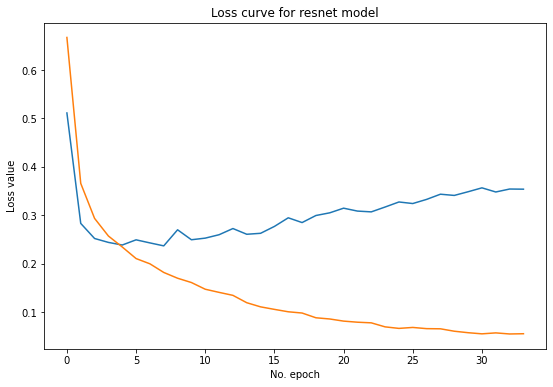

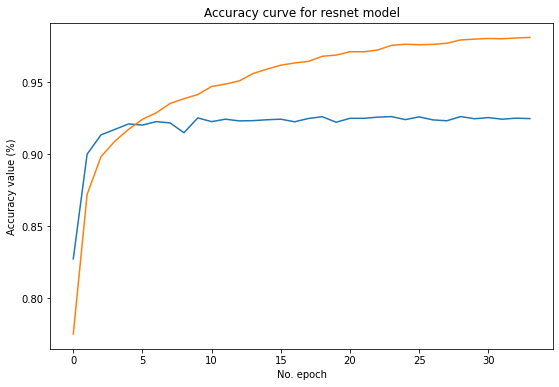

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize = (9,6))
plt.plot(history.history['val_loss'],label='Test loss')
plt.plot(history.history['loss'],label='Train loss')
plt.title('Loss curve for resnet model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history.history['val_accuracy'],label = 'Test accuracy')
plt.plot(history.history['accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for resnet model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()


In [7]:
import keras,os
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D , Dropout
import numpy as np
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from keras import regularizers
from absl import app, flags

# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:


def make_prediction(model , image , true_value):
  true_label_index = -1
  for i in range(len(true_value)):

    if(true_value[i]==1):
      true_label_index = i
      break

  prediction = model.predict(image)[0]
  probability = float('-inf')
  predicted_label_index = -1

  for i in range(len(prediction)):

    if(prediction[i]>probability):
      probability = prediction[i]
      predicted_label_index = i

  if(true_label_index!=predicted_label_index):
    return 1
  return 0

model = keras.models.load_model(model_path)

In [10]:
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1


Epsilon value -  0.1

0.1   0
1   1
0.1   1
2   2
0.1   2
3   3
0.1   3
3   3
0.1   4
3   3
0.1   5
4   4
0.1   6
4   4
0.1   7
5   5
0.1   8
5   5
0.1   9
5   5
0.1   10
6   6
0.1   11
6   6
0.1   12
6   6
0.1   13
6   6
0.1   14
6   6
0.1   15
6   6
0.1   16
6   6
0.1   17
6   6
0.1   18
6   6
0.1   19
6   6
0.1   20
6   6
0.1   21
6   6
0.1   22
6   6
0.1   23
7   6
0.1   24
8   7
0.1   25
8   7
0.1   26
8   7
0.1   27
8   7
0.1   28
8   7
0.1   29
9   8
0.1   30
9   8
0.1   31
9   8
0.1   32
9   8
0.1   33
10   9
0.1   34
11   10
0.1   35
12   11
0.1   36
12   11
0.1   37
13   12
0.1   38
13   12
0.1   39
14   12
0.1   40
15   13
0.1   41
15   13
0.1   42
15   13
0.1   43
15   13
0.1   44
15   13
0.1   45
15   13
0.1   46
15   13
0.1   47
15   13
0.1   48
16   14
0.1   49
16   14
0.1   50
16   14
0.1   51
16   14
0.1   52
16   14
0.1   53
16   14
0.1   54
16   14
0.1   55
16   14
0.1   56
16   14
0.1   57
16   14
0.1   58
16   14
0.1   59
16   14
0.1   60
17   14
0.1   61
18   15
0

In [11]:
for key in result.keys():
  print(key,' ',result[key])

0.1   (46, 52)
0.2   (73, 91)
0.30000000000000004   (94, 119)
0.4   (108, 138)
0.5   (120, 138)
0.6   (125, 138)
0.7   (133, 138)
0.7999999999999999   (140, 138)


cifar-10

In [ ]:
model = keras.models.load_model(model_path)
from keras.preprocessing.image import img_to_array

epsilon_end = 0.8
#logits_model = tf.keras.Model(model.input,model.layers[-1].output)
total_images = 200

result={}
epsilon = 0.1
while(epsilon <= epsilon_end):

  fgsm_counter = 0
  pgd_counter = 0
  print("Epsilon value - ",epsilon)
  print()
  for image_index in range(total_images):
  
  
    image = x_test[image_index]
    image = img_to_array(image)
    image = image.reshape(1, 32, 32, 3)
    true_value = y_test[image_index]
    original_prediction = make_prediction(model,image,true_value)
    fgsm_sample = fast_gradient_method(model, image, epsilon, np.inf, targeted=False)
    pgd_sample = projected_gradient_descent(model, image, epsilon, 0.01, 40, np.inf)
    print(epsilon,' ',image_index)
    fgsm_prediction = make_prediction(model , fgsm_sample , true_value)
    pgd_prediction = make_prediction(model , pgd_sample , true_value)
    pgd_counter+=pgd_prediction
    fgsm_counter+=fgsm_prediction
    print(pgd_counter,' ',fgsm_counter)
  result[epsilon] = (fgsm_counter , pgd_counter)
  epsilon+=0.1


Epsilon value -  0.1



In [ ]:
for key in result.keys():
  print(key,' ',result[key])